<a href="https://colab.research.google.com/github/LauraMattz/mit-data-science-decision-making/blob/main/kmeans_alfabetiza_brasil_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means na prática (dados reais do Brasil) 🇧🇷

Este notebook usa **dados reais** do programa **Alfabetiza Brasil (INEP)** para agrupar (clusterizar) as **Unidades da Federação (UFs)** com **K-Means**.

Agrupar estados com perfis parecidos de:
- **% de alunos alfabetizados (2024)**
- **% de participação na avaliação**

Assim dá para discutir *“quem está parecido com quem”* e por quê — sem rotular como “melhor/pior”, mas como **perfis diferentes**.

> Fonte dos dados (planilha oficial INEP): `resultados_e_metas_ufs_2024_2.xlsx` (Alfabetiza Brasil)


In [1]:
# Baixar planilha oficial do INEP (Alfabetiza Brasil)
import pandas as pd

url = "https://download.inep.gov.br/alfabetiza_brasil/resultados_e_metas_ufs_2024_2.xlsx"
arquivo = "ica_ufs_2024.xlsx"

!wget -q -O {arquivo} {url}

raw = pd.read_excel(arquivo)
raw.head()


,ANO DA AVALIAÇÃO,CÓDIGO UF,SIGLA UF,NOME UF,REDE,PERCENTUAL DE ALUNOS ALFABETIZADOS Sistemas estaduais de avaliação 2023,PERCENTUAL DE ALUNOS ALFABETIZADOS Sistemas estaduais de avaliação 2024,META 2024 (2),META 2025,META 2026,META 2027,META 2028,META 2029,META 2030,PERCENTUAL DE PARTICIPAÇÃO
0,ANO,CD_UF,SIGLA_UF,NOME_UF,REDE,PC_ALUNO_ALFABETIZADO_2023,PC_ALUNO_ALFABETIZADO_2024,META_FINAL_2024,META_FINAL_2025,META_FINAL_2026,META_FINAL_2027,META_FINAL_2028,META_FINAL_2029,META_FINAL_2030,PC_AVALIADOS_LP
1,2024,NaN,NaN,Brasil,PÚBLICA,55.9,59.197271,59.9,63.77,67.47,70.97,74.23,77.24,> 80,87.37
2,2024,12,AC,Acre,PÚBLICA,-,51.38,-,56.9,62.2,67.3,72,76.2,> 80,80.869222
3,2024,27,AL,Alagoas,PÚBLICA,43.88,48.63,49.7,55.5,61.1,66.5,71.5,76,> 80,93.783968
4,2024,13,AM,Amazonas,PÚBLICA,52.2,49.17,56.8,61.3,65.6,69.6,73.4,76.9,> 80,79.494774


## 1) Limpeza

A primeira linha (linha 0) traz nomes técnicos das colunas; a partir da linha 1 estão os dados.
Vamos:
- renomear colunas para nomes curtos
- converter números (inclui valores como `> 80` e `-`)
- manter apenas as **UFs** (sem a linha do Brasil agregado)


In [2]:
import numpy as np, re

rename = {
 'ANO DA AVALIAÇÃO':'ano','CÓDIGO UF':'cod_uf','SIGLA UF':'uf','NOME UF':'nome_uf','REDE':'rede',
 'PERCENTUAL DE ALUNOS ALFABETIZADOS Sistemas estaduais de avaliação 2023':'alf_2023',
 'PERCENTUAL DE ALUNOS ALFABETIZADOS Sistemas estaduais de avaliação 2024':'alf_2024',
 'META 2024 (2)':'meta_2024',
 'PERCENTUAL DE PARTICIPAÇÃO':'participacao'
}

def parse_num(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x,(int,float,np.integer,np.floating)):
        return float(x)
    s=str(x).strip().replace(",",".")
    if s in {"-", "–", "—", ""}:
        return np.nan
    m=re.search(r"(-?\d+(\.\d+)?)", s)   # pega primeiro número (ex.: "> 80" -> 80)
    return float(m.group(1)) if m else np.nan

data = raw.iloc[1:].copy().reset_index(drop=True).rename(columns=rename)

for c in ['alf_2023','alf_2024','meta_2024','participacao']:
    data[c] = data[c].apply(parse_num)

data['cod_uf'] = pd.to_numeric(data['cod_uf'], errors='coerce')

ufs = data[data['cod_uf'].notna()].dropna(subset=['alf_2024','participacao']).copy()
ufs['gap_meta_2024'] = ufs['alf_2024'] - ufs['meta_2024']

ufs[['uf','nome_uf','alf_2024','participacao','meta_2024','gap_meta_2024']].sort_values('alf_2024', ascending=False).head(10)


,uf,nome_uf,alf_2024,participacao,meta_2024,gap_meta_2024
6,CE,Ceará,85.31,98.126774,80.0,5.31
9,GO,Goiás,72.74,92.078733,68.9,3.84
11,MG,Minas Gerais,72.07,88.853063,63.2,8.87
8,ES,Espírito Santo,71.69,89.936512,69.9,1.79
18,PR,Paraná,70.42,86.245321,74.2,-3.78
21,RO,Rondônia,62.62,88.331275,67.1,-4.48
24,SC,Santa Catarina,62.02,70.051040,64.5,-2.48
16,PE,Pernambuco,60.79,94.754853,62.4,-1.61
13,MT,Mato Grosso,60.59,88.458746,59.2,1.39
17,PI,Piauí,59.82,95.090865,57.0,2.82


## 2) O que é K-Means

O K-Means tenta responder:
> “Se eu tiver **K grupos**, qual é a forma de dividir os pontos para que cada ponto fique **o mais perto possível** do ‘centro’ do seu grupo?”

- Cada grupo tem um **centroide** (uma média).
- O algoritmo alterna:
  1. **Atribui** cada ponto ao centroide mais próximo  
  2. **Recalcula** os centroides (médias dos pontos do grupo)
- Para de repetir quando quase não muda mais.

⚠️ Importante:  
Se as variáveis estão em escalas diferentes, uma “domina” o cálculo da distância. Por isso usamos **padronização** (StandardScaler).


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = ['alf_2024','participacao']
X = ufs[features].to_numpy()

Xz = StandardScaler().fit_transform(X)

# Vamos testar alguns K
ks = range(2, 7)
inertias, sils = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=30, random_state=42)
    labels = km.fit_predict(Xz)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(Xz, labels))

list(zip(ks, [round(v,3) for v in inertias], [round(v,3) for v in sils]))


[(2, 28.871, np.float64(0.394)),
 (3, 18.928, np.float64(0.425)),
 (4, 13.477, np.float64(0.414)),
 (5, 9.349, np.float64(0.429)),
 (6, 6.575, np.float64(0.437))]

## 3) Visual: “cotovelo” (inércia) + silhouette

- **Elbow (inércia/SSE):** cai conforme K aumenta; procuramos o “joelho” (quando a queda começa a ficar pequena).
- **Silhouette:** mede separação entre clusters (quanto maior, melhor).  
  Para conjuntos pequenos, às vezes “puxa” para K maior — aí você usa também o bom senso (evitar clusters de 1 estado, por exemplo).


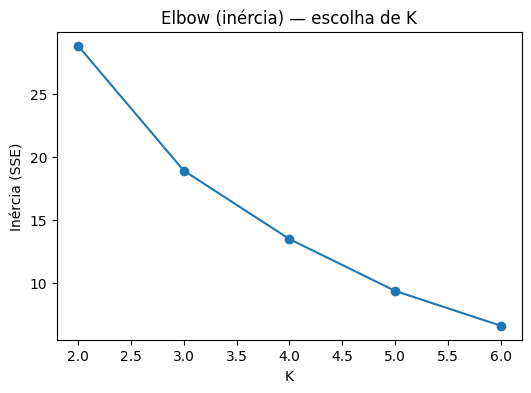

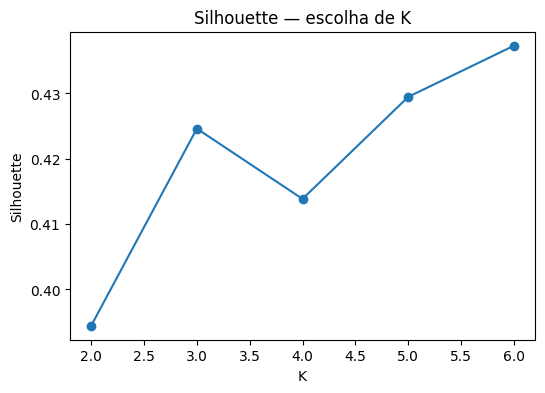

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(list(ks), inertias, marker='o')
plt.title("Elbow (inércia) — escolha de K")
plt.xlabel("K")
plt.ylabel("Inércia (SSE)")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(list(ks), sils, marker='o')
plt.title("Silhouette — escolha de K")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()


## 4) Rodar o K-Means

Agora a parte legal: ver os grupos e explicar o que eles representam.


In [5]:
k = 4
km = KMeans(n_clusters=k, n_init=50, random_state=42)
ufs['cluster'] = km.fit_predict(Xz)

ufs.groupby('cluster')[['alf_2024','participacao']].agg(['mean','min','max','count']).round(2)


alf_2024                     participacao                    
            mean    min    max count         mean    min    max count
cluster                                                              
0          59.18  55.87  62.62     8        90.62  88.29  95.09     8
1          42.40  35.96  48.63     4        91.45  89.14  93.78     4
2          51.02  39.29  62.02     9        80.26  70.05  85.15     9
3          74.45  70.42  85.31     5        91.05  86.25  98.13     5

## 5) Gráficos

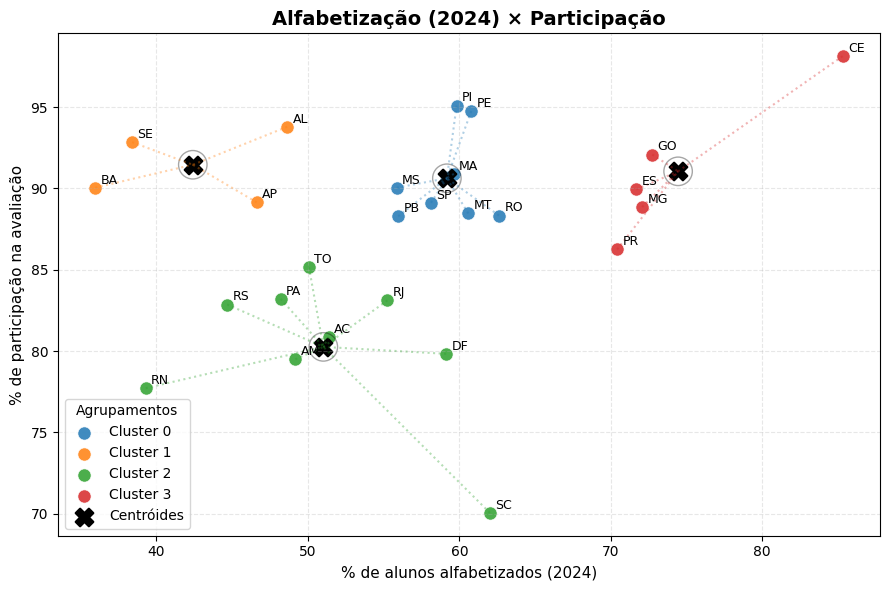


🧠 ANÁLISE DOS RESULTADOS — K-MEANS (ALFABETIZAÇÃO 2024)

🔹 CLUSTER 0
   Alfabetização média: 59.2%
   Participação média: 90.6%

   🔵 Perfil intermediário com potencial de avanço.
   • A combinação de participação razoável e alfabetização mediana
     sugere espaço para ganhos rápidos com ajustes de gestão pedagógica.
   🎯 Ação recomendada: uso de dados para direcionar apoio técnico
     e fortalecer práticas já existentes.

----------------------------------------------------------------------

🔹 CLUSTER 1
   Alfabetização média: 42.4%
   Participação média: 91.5%

   🔴 Desafio estrutural de aprendizagem.
   • A alta participação indica que o problema não é falta de diagnóstico,
     mas sim dificuldade de garantir alfabetização na idade certa.
   • Políticas genéricas tendem a falhar nesse perfil.
   🎯 Ação recomendada: intervenção pedagógica intensiva, formação docente
     e acompanhamento individualizado.

----------------------------------------------------------------------

🔹 

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# =========================
# Configurações visuais
# =========================
colors = {
    0: "#1f77b4",  # azul
    1: "#ff7f0e",  # laranja
    2: "#2ca02c",  # verde
    3: "#d62728",  # vermelho
}

plt.figure(figsize=(9,6))

# =========================
# Plot dos clusters
# =========================
for c in sorted(ufs['cluster'].unique()):
    sub = ufs[ufs['cluster'] == c]
    plt.scatter(
        sub['alf_2024'],
        sub['participacao'],
        s=90,
        color=colors[c],
        edgecolor="white",
        linewidth=0.5,
        alpha=0.85,
        label=f"Cluster {c}"
    )

# =========================
# Centróides (média real)
# =========================
centers = (
    ufs
    .groupby('cluster')[['alf_2024', 'participacao']]
    .mean()
    .values
)

# X menor
plt.scatter(
    centers[:,0],
    centers[:,1],
    marker="X",
    s=160,               # ⬅️ menor que antes
    c="black",
    linewidth=1.6,
    label="Centróides"
)

# Halo proporcional
plt.scatter(
    centers[:,0],
    centers[:,1],
    marker="o",
    s=420,               # ⬅️ reduzido também
    facecolors="none",
    edgecolors="black",
    linewidth=1.0,
    alpha=0.35
)

# =========================
# Linhas UF → centróide
# =========================
for _, r in ufs.iterrows():
    cx, cy = centers[int(r['cluster'])]
    plt.plot(
        [r['alf_2024'], cx],
        [r['participacao'], cy],
        linestyle=":",
        color=colors[int(r['cluster'])],
        alpha=0.35
    )

# =========================
# Rótulos das UFs
# =========================
for _, r in ufs.iterrows():
    plt.text(
        r['alf_2024'] + 0.35,
        r['participacao'] + 0.25,
        r['uf'],
        fontsize=9
    )

# =========================
# Estética final
# =========================
plt.title(
    "Alfabetização (2024) × Participação",
    fontsize=14,
    weight="bold"
)
plt.xlabel("% de alunos alfabetizados (2024)", fontsize=11)
plt.ylabel("% de participação na avaliação", fontsize=11)

plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Agrupamentos")
plt.tight_layout()
plt.show()

# =========================
# INSIGHTS ESTRATÉGICOS — CONTEXTO EDUCACIONAL BRASILEIRO
# =========================

print("\n🧠 ANÁLISE DOS RESULTADOS — K-MEANS (ALFABETIZAÇÃO 2024)\n")

centers_df = (
    ufs
    .groupby('cluster')[['alf_2024', 'participacao']]
    .mean()
    .sort_index()
)

for c, row in centers_df.iterrows():
    alf = row['alf_2024']
    part = row['participacao']

    print(f"🔹 CLUSTER {c}")
    print(f"   Alfabetização média: {alf:.1f}%")
    print(f"   Participação média: {part:.1f}%\n")

    # Interpretação contextual
    if alf >= 70 and part >= 90:
        print(
            "   🟢 Perfil consolidado de alfabetização.\n"
            "   • O alto nível de alfabetização combinado com ampla participação\n"
            "     sugere políticas consistentes e capacidade de execução em larga escala.\n"
            "   • Esses estados podem atuar como polos de referência e cooperação federativa.\n"
            "   🎯 Ação recomendada: sistematizar e difundir boas práticas pedagógicas."
        )

    elif alf < 50 and part >= 90:
        print(
            "   🔴 Desafio estrutural de aprendizagem.\n"
            "   • A alta participação indica que o problema não é falta de diagnóstico,\n"
            "     mas sim dificuldade de garantir alfabetização na idade certa.\n"
            "   • Políticas genéricas tendem a falhar nesse perfil.\n"
            "   🎯 Ação recomendada: intervenção pedagógica intensiva, formação docente\n"
            "     e acompanhamento individualizado."
        )

    elif alf < 55 and part < 85:
        print(
            "   🟡 Fragilidade de cobertura e aprendizagem.\n"
            "   • A baixa participação compromete a confiabilidade do diagnóstico.\n"
            "   • Resultados de alfabetização podem estar subestimados ou distorcidos.\n"
            "   🎯 Ação recomendada: ampliar participação antes de usar resultados\n"
            "     para decisões de política pública."
        )

    else:
        print(
            "   🔵 Perfil intermediário com potencial de avanço.\n"
            "   • A combinação de participação razoável e alfabetização mediana\n"
            "     sugere espaço para ganhos rápidos com ajustes de gestão pedagógica.\n"
            "   🎯 Ação recomendada: uso de dados para direcionar apoio técnico\n"
            "     e fortalecer práticas já existentes."
        )

    print("\n" + "-"*70 + "\n")

print(
    "📌 SÍNTESE GERAL\n"
    "Os resultados mostram que o Brasil apresenta perfis educacionais distintos\n"
    "em alfabetização e participação. O uso de K-Means permite superar análises\n"
    "uniformes e orientar estratégias diferenciadas, respeitando o estágio\n"
    "de desenvolvimento de cada grupo de estados.\n\n"
    "Em termos de política pública, os clusters sugerem que:\n"
    "• não existe uma única solução para todos;\n"
    "• intervenções devem ser priorizadas conforme perfil;\n"
    "• estados com bom desempenho podem atuar como referências;\n"
    "• ampliar participação é pré-condição para decisões baseadas em evidências."
)


- Mapa do Brasil


In [ ]:
pip install geobr

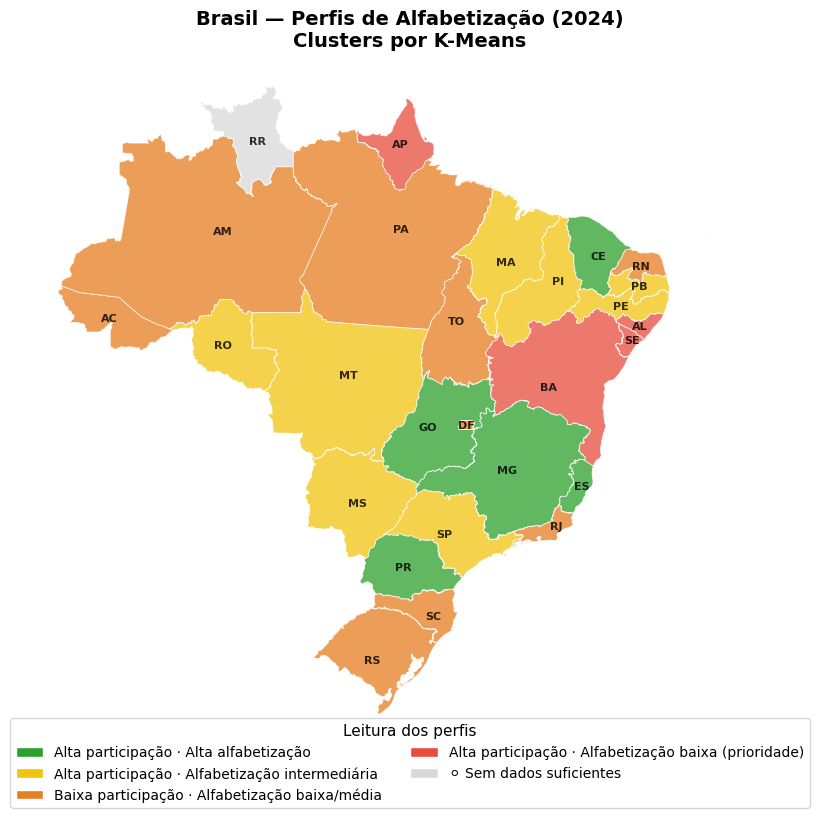

In [10]:
import geopandas as gpd
import geobr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# =========================
# PALETA SEMAFÓRICA
# =========================
cluster_info = {
    3: {"color": "#2ca02c", "label": "Alta participação · Alta alfabetização"},
    0: {"color": "#f1c40f", "label": "Alta participação · Alfabetização intermediária"},
    2: {"color": "#e67e22", "label": "Baixa participação · Alfabetização baixa/média"},
    1: {"color": "#e74c3c", "label": "Alta participação · Alfabetização baixa (prioridade)"},
}

# =========================
# MALHA DAS UFs
# =========================
gdf_uf = geobr.read_state(year=2020)
gdf_uf['uf'] = gdf_uf['abbrev_state']

# =========================
# MERGE COM CLUSTERS
# =========================
mapa = gdf_uf.merge(
    ufs[['uf', 'cluster']],
    on='uf',
    how='left'
)

# Cor por cluster
mapa['cor'] = mapa['cluster'].map({k: v["color"] for k, v in cluster_info.items()})
mapa['cor'] = mapa['cor'].fillna("#d9d9d9")

# =========================
# PLOT DO MAPA (cores opacas)
# =========================
fig, ax = plt.subplots(1, 1, figsize=(10,10))

mapa.plot(
    ax=ax,
    color=mapa['cor'],
    linewidth=0.6,
    edgecolor='white',
    alpha=0.75   # ⬅️ OPACIDADE AQUI
)

ax.set_title(
    "Brasil — Perfis de Alfabetização (2024)\nClusters por K-Means",
    fontsize=14,
    weight='bold'
)

ax.axis('off')

# =========================
# RÓTULOS DAS UFs (menores)
# =========================
for _, row in mapa.iterrows():
    if row['uf'] is not None:
        x, y = row.geometry.representative_point().coords[0]
        ax.text(
            x, y,
            row['uf'],
            ha='center',
            va='center',
            fontsize=8,      # ⬅️ MENOR
            weight='bold',
            color='black',
            alpha=0.8        # ⬅️ um pouco mais suave
        )

# =========================
# LEGENDA
# =========================
legend_elements = [
    Patch(facecolor=v["color"], edgecolor="white", label=v["label"])
    for v in cluster_info.values()
]

legend_elements.append(
    Patch(facecolor="#d9d9d9", edgecolor="white", label="⚪ Sem dados suficientes")
)

ax.legend(
    handles=legend_elements,
    title="Leitura dos perfis",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    frameon=True,
    fontsize=10,
    title_fontsize=11
)

plt.show()


In [9]:
print("\n📌 AVALIAÇÃO GERAL DA ALFABETIZAÇÃO NO BRASIL — 2024\n")

print(
    "Resumo geral:\n"
    "O Brasil avançou de forma importante na capacidade de avaliar a alfabetização,\n"
    "mas ainda enfrenta um desafio significativo para garantir que todas as crianças\n"
    "se alfabetizem na idade certa.\n"
)

print(
    "1) Avanços observados:\n"
    "- A participação nas avaliações é alta na maior parte do país (frequentemente acima de 85–90%).\n"
    "- Isso indica maior confiabilidade dos dados e melhor capacidade de diagnóstico.\n"
    "- O país hoje sabe com mais clareza onde estão os principais desafios.\n"
)

print(
    "2) Principais desafios:\n"
    "- Os níveis de alfabetização ainda são desiguais entre os estados.\n"
    "- Apenas uma parte do país atinge patamares elevados de alfabetização (≈70–85%).\n"
    "- Um grupo relevante apresenta alfabetização intermediária ou baixa,\n"
    "  mesmo com alta participação nas avaliações.\n"
)

print(
    "3) O que os clusters revelam:\n"
    "- Existe uma minoria de estados com alto desempenho e alta participação,\n"
    "  mostrando que é possível alfabetizar bem em escala no Brasil.\n"
    "- Um grande grupo está em situação intermediária, com potencial de ganhos rápidos\n"
    "  a partir de ajustes pedagógicos e de gestão.\n"
    "- Um grupo crítico apresenta baixa alfabetização apesar de boa cobertura,\n"
    "  demandando intervenções estruturadas e contínuas.\n"
)

print(
    "4) Leitura nacional:\n"
    "- O principal desafio atual não é mais a falta de dados, mas transformar\n"
    "  diagnósticos em políticas públicas eficazes.\n"
    "- Estratégias uniformes tendem a ser pouco efetivas diante de perfis tão distintos.\n"
)

print(
    "Conclusão:\n"
    "Em 2024, o Brasil se encontra em um ponto de transição: saiu de um cenário de\n"
    "diagnóstico limitado para um cenário de maior clareza sobre a alfabetização.\n"
    "O desafio agora é usar essas evidências para orientar ações diferenciadas,\n"
    "capazes de garantir a alfabetização na idade certa para todas as crianças.\n"
)



📌 AVALIAÇÃO GERAL DA ALFABETIZAÇÃO NO BRASIL — 2024

Resumo geral:
O Brasil avançou de forma importante na capacidade de avaliar a alfabetização,
mas ainda enfrenta um desafio significativo para garantir que todas as crianças
se alfabetizem na idade certa.

1) Avanços observados:
- A participação nas avaliações é alta na maior parte do país (frequentemente acima de 85–90%).
- Isso indica maior confiabilidade dos dados e melhor capacidade de diagnóstico.
- O país hoje sabe com mais clareza onde estão os principais desafios.

2) Principais desafios:
- Os níveis de alfabetização ainda são desiguais entre os estados.
- Apenas uma parte do país atinge patamares elevados de alfabetização (≈70–85%).
- Um grupo relevante apresenta alfabetização intermediária ou baixa,
  mesmo com alta participação nas avaliações.

3) O que os clusters revelam:
- Existe uma minoria de estados com alto desempenho e alta participação,
  mostrando que é possível alfabetizar bem em escala no Brasil.
- Um grande gr